##　1.1 案例分析

下圖將通過一個真實世界數據的案例對 DoWhy 的流程進行進一步探討。

在本例中，我們的研究問題是估計當消費者在預定酒店時，為其分配一間與之前預定過的房間**不同的房間**對消費者取消當前預定的影響。

分析此類問題的標準是「隨機對照試驗」（Randomized Controlled Trials），即每位消費者被隨機分配到兩類干預中的一類：為其分配與之前預定過的房間相同或不同的房間。

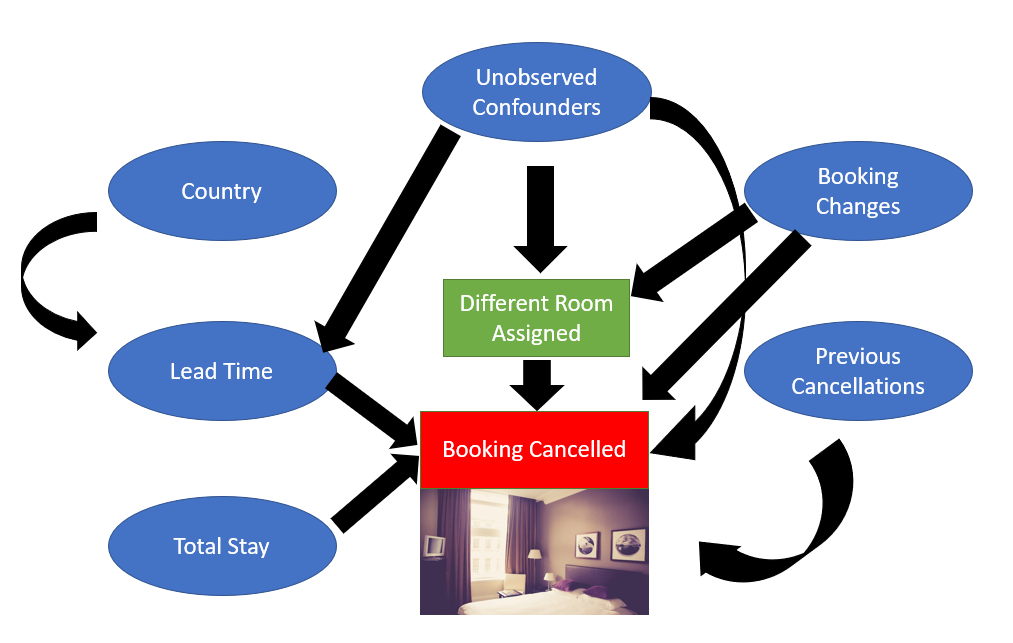


然而，實際上對於酒店來說不可能進行這樣的試驗，只能使用歷史數據（觀察性數據）來進行評估。我們首先導入相關library與數據集：

In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger("dowhy").setLevel(logging.INFO)

dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## 1.2 數據前處理

下面我們將產生一些有用的特徵，來減少原始數據的維度。具體來說，我們將產生如下三個特徵：
* 「Total Stay」 = stays_in_weekend_nights + stays_in_week_nights
* 「Guests」 = adults + children + babies
* 「Different_room_assigned」 = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise

具體如下:

In [2]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

之後再對缺失值與Boolean值進行預處理，並去除部分特徵

In [3]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True) # 新增对NA值的处理
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')

## 1.3 假設

數據前處理完成後，我們首先針對數據進行一定的分析，考察變量之間的關係。

針對目標變量 is_cancelled 與 different_room_assigned ，我們隨機選取 1000 次查看有多少次上述兩個變量的值相同（即可能存在因果關係），
重複上述過程 10000 次取平均，程式碼如下：

In [5]:
counts_sum = 0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
        
counts_sum/10000

最終得出的期望值是 **「518」**，即兩個變量有約 50% 的時間是不同的，
我們還無法判斷其中的因果關係。
下面我們進一步分析預約過程中沒有發生調整時（即變量 booking_changes 為 0） 兩個變量相等的期望值：

In [6]:
# Expected Count when there are no booking changes = 49.2%
counts_sum = 0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
        
counts_sum/10000

得出的結果為 **「492」**。隨後我們再分析預約過程中發生調整時的期望值：

In [8]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

結果變成了 **「663」**，與之前產生了明顯的差異。

我們可以不嚴謹地認為預約調整這一變量是一個「混雜因子」。

同樣地，我們對其他變量進行分析，並作出一些假設，作為因果推斷的先驗知識。 

DoWhy 並不需要完整的先驗知識，未指明的變量將作為潛在的混雜因子進行推斷。
在本例中，我們將給出如下的假設：

* market_segment 參數有兩種：TA 指旅行者，TO 指旅遊公司，該參數會影響 lead_time（即預約和到達之間的時間間隔）
* country 參數會決定一個人是否會提早預訂（即影響 lead_time ）以及其喜愛的食物（即影響 meal）
* lead_time 會影響預訂的等待時間（ days_in_waiting_list ）
* 預訂的等待時間 days_in_waiting_list、總停留時間 total_stay 以及客人數量 guests 會影響預訂是否被取消
* 之前預訂的取消情況 previous_bookings_not_canceled 會影響該顧客是否為 is_repeated_guest；這兩個變量也會影響預訂是否被取消
* booking_changes 會影響顧客是否被分配到不同的房間，也會影響預訂取消情況
* 除了 booking_changes 這一混雜因子外，一定還存在著其他混雜因子，同時影響干預和結果

## 1.4 因果推斷

### 1.4.1 創建因果圖

基於上述假設，我們通過gml來構建因果圖:

In [4]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

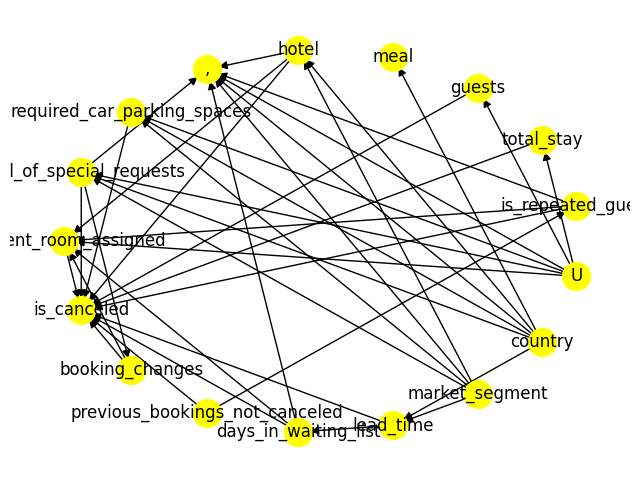

In [5]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()

## 1.4.2 辨識因果效應

下面我們將使用因果圖的屬性來識別因果效應的估計量。

In [6]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_stay,booking_changes,lead_time,
d[different_room_assigned]                                                    

                                                                              
days_in_waiting_list,guests,required_car_parking_spaces,hotel,total_of_special
                                                                              

                             
_requests,is_repeated_guest])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_stay,booking_changes,lead_time,days_in_waiting_list,guests,required_car_parking_spaces,hotel,total_of_special_requests,is_repeated_guest,U) = P(is_canceled|different_room_assigned,total_

## 1.4.3 評估因果效應

基於估計量，下面我們就可以根據實際數據進行因果效應的估計了。

DoWhy 支持採用各種各樣的方法計算因果效應估計量，並最終返回單個平均值。程式碼如下：

In [7]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

C:\Users\pei4b\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_stay,booking_changes,lead_time,
d[different_room_assigned]                                                    

                                                                              
days_in_waiting_list,guests,required_car_parking_spaces,hotel,total_of_special
                                                                              

                             
_requests,is_repeated_guest])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_stay,booking_changes,lead_time,days_in_waiting_list,guests,required_car_parking_spaces,hotel,total_of_special_requests,is_repeated_guest,U

## 1.4.4 反駁結果

實際上，上述因果並不是基於數據，而是基於我們所做的假設（即提供的因果圖），數據只是用於進行統計學的估計。因此，我們需要驗證假設的正確性。 
DoWhy 支持通過各種各樣的檢查方法來測試假設的正確性。下面進行其中幾項測試：

### 「添加隨機混雜因子」。如果假設正確，則添加隨機的混雜因子後，因果效應不會變化太多。

In [21]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:-0.25904752852855156
New effect:-0.2590475285285515
p value:2.0



### 「安慰劑干預」。將干預替換為隨機變量，如果假設正確，因果效應應該接近 0。

In [22]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.25904752852855156
New effect:0.00020234199046077541
p value:0.96



### 「數據子集驗證」。在數據子集上估計因果效應，如果假設正確，因果效應應該變化不大。

In [8]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.2624820635564158
New effect:-0.26436037619504427
p value:0.5800000000000001



---

可以看到，我們的因果模型基本可以通過上述幾個測試（即取得預期的結果）。

因此，根據估計階段的結果，我們得出結論：

當消費者在預定房間時，為其**分配之前預定過的房間（different_room_assigned = 0）所導致的平均預定取消機率（is_canceled）**
比 **分配不同的房間（different_room_assigned = 1）** 低 **「33%」**。